In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import random
from operator import itemgetter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC

import cv2

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

from itertools import count
iid = count()

SEED = 42    # random state seed for consistent results

### 0. Preprocessing

In [2]:
%%time
# mini_X = np.loadtxt("./Datasets/mini_train_x.csv", delimiter=",")
# mini_y = np.loadtxt("./Datasets/mini_train_y.csv", delimiter=",")

mini_X = np.loadtxt("./Datasets/train_x.csv", delimiter=",")
mini_y = np.loadtxt("./Datasets/train_y.csv", delimiter=",")

# mini_X = np.loadtxt("./Datasets/train_x.csv", delimiter=",")
# mini_y = np.loadtxt("./Datasets/train_y.csv", delimiter=",")

CPU times: user 2min 15s, sys: 1.86 s, total: 2min 17s
Wall time: 2min 17s


#### Reshape to easily visualize while cleaning data

In [3]:
%%time
x = mini_X.reshape(-1, 64, 64)

imgs = []
for idx in range(len(x)):
    img_id = next(iid)
    cv2.imwrite('Output/{}.jpg'.format(img_id), 255-x[idx])
    imgs.append(cv2.imread('Output/{}.jpg'.format(img_id), 0))

CPU times: user 4.25 s, sys: 1.22 s, total: 5.48 s
Wall time: 5.49 s


We will first transform to binary image (black, white):

In [4]:
%%time
bin_imgs = []
for img in imgs:
    _, bin_img = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    bin_imgs.append(bin_img)

CPU times: user 95.8 ms, sys: 1 ms, total: 96.8 ms
Wall time: 96.4 ms


Then we will remove the noice by dilatating and eroding the image:

In [5]:
%%time
denoised_imgs = []
for bin_img in bin_imgs:
    dilatated = cv2.dilate(bin_img, np.ones((3,3)))
    denoised_imgs.append(cv2.erode(dilatated, np.ones((2,2))))

CPU times: user 702 ms, sys: 0 ns, total: 702 ms
Wall time: 702 ms


Finally, find largest contour:

In [6]:
%%time
MAX_AREA = 60*60   # avoid getting the 64X64 image as a contour
def get_coords_largest_digit(contours):
    x=y=w=h=0
    max_contour = 0
    for idx, cont in enumerate(contours):
        a = cv2.contourArea(cont,False)
        if a > max_contour and a < MAX_AREA:
            x,y,w,h = cv2.boundingRect(cont)
            max_contour = a

    return x,y,w,h
 
discarted = 0
MAX_ALLOWED_LENGTH = 36
largest_digits = []
idx_to_del = []
for idx, img in enumerate(denoised_imgs.copy()):
    _, contours, _ = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    x,y,w,h = get_coords_largest_digit(contours)
    cropped_img = img[y+1:y+h, x+1:x+w]
    
    vertical = int((MAX_ALLOWED_LENGTH-h) / 2)
    horizontal = int((MAX_ALLOWED_LENGTH-w) / 2)

    if h > MAX_ALLOWED_LENGTH or w > MAX_ALLOWED_LENGTH:
        discarted +=1
        idx_to_del.append(idx)
        continue

    resized_img = cv2.copyMakeBorder(cropped_img,vertical,vertical,horizontal,horizontal,cv2.BORDER_CONSTANT, value=[255,255,255])
    largest_digits.append(resized_img[2:34,2:34])
    
mini_y = np.delete(mini_y, idx_to_del, axis=0)

print('Discarted {} samples because preprocessing failed to clean well the image.'.format(discarted))

Discarted 620 samples because preprocessing failed to clean well the image.
CPU times: user 1.26 s, sys: 3 ms, total: 1.26 s
Wall time: 1.26 s


Lets visualize the transformations:

4 5


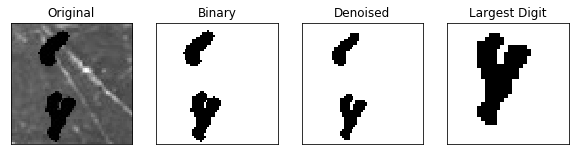

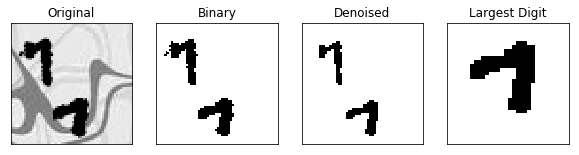

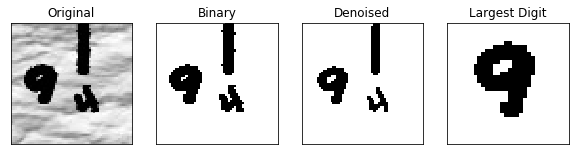

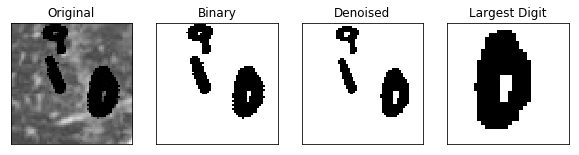

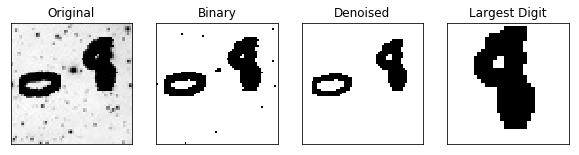

In [7]:
def plot_images(images, titles):
    cols = len(images)
    rows = len(images[0])
    
    print(cols, rows)
    for r in range(rows):
        for c in range(cols):
            plt.subplot(1,cols,c+1)
            plt.imshow(images[c][r],'gray')
            plt.title(titles[c])
            plt.xticks([]),plt.yticks([])
        
        plt.show()
        
titles = ['Original', 'Binary', 'Denoised', 'Largest Digit']
images = [imgs[:5], bin_imgs[:5], denoised_imgs[:5], largest_digits[:5]]
plot_images(images, titles)

#### Split the clean data

In [8]:
clean_X = []
for i in range(len(largest_digits)):
    clean_X.append(largest_digits[i].flatten())

clean_X = np.divide(255-np.array(clean_X),255)

mini_X_train, mini_X_test, mini_y_train, mini_y_test = train_test_split(clean_X, mini_y, 
                                                                        test_size=0.3,
                                                                       random_state=SEED)

### 1. Linear Learners

In [9]:
%%time
# hyperparameter permutations
FOLDS = 3 
DUAL = [False] 
LOSSES = ['squared_hinge','hinge']
PENALTIES = ['l1','l2']
SOLVERS = ['lbfgs']

KFOLD = KFold(n_splits=FOLDS, random_state=SEED)

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 18.8 µs


#### Base and dummy clf performances for reference

In [10]:
%%time
# dummy clf performance
random_clf = DummyClassifier(random_state=42)
result = cross_val_score(random_clf, mini_X_train, mini_y_train, cv=KFOLD, scoring='accuracy')
print('Random clf performance: {:.4f}'.format(result.mean()))

# Base performance (default HP)
result = cross_val_score(LinearSVC(), mini_X_train, mini_y_train, cv=KFOLD, scoring='accuracy')
print('LinearSVM base performance: {:.4f}'.format(result.mean()))

result = cross_val_score(LogisticRegression(), mini_X_train, mini_y_train, cv=KFOLD, scoring='accuracy')
print('LogReg base performance: {:.4f}'.format(result.mean()))

Random clf performance: 0.0973
LinearSVM base performance: 0.3583
LogReg base performance: 0.4460
Wall time: 15.8 s


#### Perform Model Selection for LinearSM

In [11]:
%%time
parameters = {'C':np.linspace(0.0005,0.001, 10)}
svc = LinearSVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy')
clf.fit(mini_X_train,mini_y_train)
print('HyperParameters chosen by CV: {}'.format(clf.best_params_ ))
print('Testing Score: {:.4f}'.format(clf.score(mini_X_test, mini_y_test)))

HyperParameters chosen by CV: {'C': 0.0009444444444444445}
Testing Score: 0.5733
Wall time: 4.66 s


#### Perform Model Selection for LogisticRegression

In [12]:
%%time

parameters = {'C':np.linspace(0.005,0.02, 10),'solver':SOLVERS,'n_jobs':[8]}
logit = LogisticRegression()
clf = GridSearchCV(logit, parameters, scoring='accuracy')
clf.fit(mini_X_train,mini_y_train)
print('HyperParameters chosen by CV: {}'.format(clf.best_params_ ))
print('Testing Score: {:.4f}'.format(clf.score(mini_X_test, mini_y_test)))

HyperParameters chosen by CV: {'C': 0.009999999999999998, 'n_jobs': 8, 'solver': 'lbfgs'}
Testing Score: 0.6023
Wall time: 3min 39s


## Neural Network

In [10]:
from neuralnet import *
one_hot_encode = lambda x: np.eye(10)[x]
one_hot_decode = lambda x: np.argmax(x)
input_length = mini_X_train.shape[1]
y_train = np.array(list(map(lambda x: one_hot_encode(int(x)), mini_y_train)))
y_test = np.array(list(map(lambda x: one_hot_encode(int(x)), mini_y_test)))
epochs = 300

In [16]:
%%time
net = NeuralNetBuilder() \
        .input_layer(input_length) \
        .add_layer("sigmoid", 60) \
        .output_layer(10) \
        .build()
        
x_valid = mini_X_test[:1500]
y_valid = mini_y_test[:1500]
validation = list(zip(x_valid, y_valid))
x_test = mini_X_test[1500:]
y_test = mini_y_test[1500:]

layer1 = [("tanh", 80), ("sigmoid", 80)]
layer2 = [None, ("sigmoid", 30), ("tanh", 30)]
gammas = np.linspace(0.005,0.1,3)

total_tries = len(layer1) * len(layer2) * len(gammas)

best_result = (0, None, None, 0)
i = 0
for l1 in layer1:
    for l2 in layer2:
        for gamma in gammas:
            i += 1
            builder = NeuralNetBuilder().input_layer(input_length).add_layer(l1[0], l1[1])
            if not (l2 is None):
                builder.add_layer(l2[0], l2[1])
            builder.output_layer(10)
            clf = builder.build()
            (errors, valids) = clf.fit(np.array(mini_X_train), y_train, epochs=20, gamma=gamma, debug=False, validation=validation)
            if valids[-1] > best_result[0]:
                best_result = (valids[-1], l1, l2, gamma)
            print("Finished trial " + str(i) + "/" + str(total_tries) + " with validation accuracy {:.2f}%".format(valids[-1]))
        
#(errors, valids) = net.fit(np.array(mini_X_train), y_train, epochs=epochs, gamma=0.05, debug=True, validation=validation)

Finished trial 1/18 with validation accuracy 59.87%


KeyboardInterrupt: 

In [15]:
if best_result[2] is None:
    print("Best result occurs with a " + best_result[1][0] + " layer of " + str(best_result[1][1]) + " units and gamma = " + str(best_result[3]))
else:
    print("Best result occurs with a " + best_result[1][0] + " layer of " + str(best_result[1][0]) + " units, a " + best_result[2][0] + " layer of " + str(best_result[2][1]) + " units, and gamma = " + str(best_result[3]))
          

Best result occurs with a sigmoid layer of 80 units and gamma = 0.1


In [ ]:
builder = NeuralNetBuilder().input_layer(input_length).add_layer(best_result[1][0], best_result[1][1])
if not (best_result[2] is None):
    builder.add_layer(best_result[2][0],best_result[2][1])
builder.ouput_layer(10)
clf = builder.build()
(errors, valids) = clf.fit(np.array(mini_X_train), y_train, epochs=300, gamma=gamma, debug=False, validation=validation)